In [32]:
import os;
import sys;
import random;
import json

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;

import tensorflow as tf
from tensorflow import keras;
import openslide
import imutils

import pylab



In [2]:
image_size = (512,512);
batch_size = 10

In [3]:
path="/home/ubuntu/data/gland_public/";

train_ids=[];
test_ids=[];
test_ids2=[];

files=os.listdir(path)
for i in files:
    i = i.replace("_anno.bmp","").replace(".bmp","");
    if i.startswith("testB"):
        test_ids2.append(i)
        
    elif i.startswith("train"):
        train_ids.append(i)
        
    elif i.startswith("testA"):
        test_ids.append(i)
        

train_ids=list(set(train_ids))
test_ids=list(set(test_ids))
test_ids2=list(set(test_ids2))




print(len(train_ids))
print(len(test_ids))
print(len(test_ids2))

85
60
20


In [34]:
class DataLoader(keras.utils.Sequence):
    def __init__(self,ids,batch_size=0,image_size=(256,256),aug=False):
        self.ids=ids;
        self.aug = aug;
        self.batch_size =batch_size;
        self.image_size = image_size;
        
        
    def __load__(self,id_name):
        
        path="/home/ubuntu/data/gland_public/";
        
        image_path = os.path.join(path,id_name)+".bmp";
        
        image = cv2.imread(image_path);
        
        
        
        mask_path= os.path.join(path,id_name)+"_anno.bmp";
        mask = cv2.imread(mask_path,-1);
        
        thresh =0.5
        mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
        
        if self.aug==True:
            
            n = random.choice([0,1]);
            
            if n ==0:
                source = openslide.open_slide(image_path);
                dimensions = source.dimensions

                image =source.read_region( (0,0),0,(dimensions[0],dimensions[1]));
                image =  np.array( image );

                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB);  
            
            
            n = random.choice([0,1]);
            if n==0:
                image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
                
            
            
            n = random.choice([0,1,3,5]);
            if n !=0:
                image = cv2.GaussianBlur(image,(n,n),cv2.BORDER_DEFAULT)
            
            n = random.choice([1,1.25,1.5,1.75,2]);
            shape = image.shape
            
            shapeY = int(shape[0]/n)
            shapeX = int(shape[1]/n)
            image = cv2.resize(image,(shapeX,shapeY))
            
            
        else:
            image =  cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
        
        
        
        n = random.choice([0,90,180,270]);
        if n !=0 and self.aug==True:
                
            image = cv2.resize(image,self.image_size);
            mask=cv2.resize(mask,self.image_size);
            
            image = imutils.rotate(image, n);
            mask = imutils.rotate(mask, n);
            
            mask = np.expand_dims(mask,axis=-1);
            mask =np.maximum(mask,mask);


            image =image/255.0;
            mask = mask/255.0;
        
        else:
        
            image = cv2.resize(image,self.image_size);
            mask=cv2.resize(mask,self.image_size);
            mask = np.expand_dims(mask,axis=-1);
            mask =np.maximum(mask,mask);


            image =image/255.0;
            mask = mask/255.0;
        
       
        
        return image, mask;
    
    def __getitem__(self,index):
        if (index+1)*self.batch_size >len(self.ids):
            self.bach_size=len(self.ids)-index*batch_size;
            
        files_batch = self.ids[index*self.batch_size:(index+1)*self.batch_size]
        
        image=[];
        mask=[];
        
        for id_name in files_batch:
            _img,_mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask);
        
        image =np.array(image)
        mask =np.array(mask);
        
        return image, mask;
    
    def on_epoch_end(self):
        pass;
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));




In [35]:
test_data = DataLoader(test_ids,batch_size=batch_size,image_size = image_size)
test_data2 = DataLoader(test_ids2,batch_size=batch_size,image_size = image_size)

(10, 512, 512, 3) (10, 512, 512, 1)


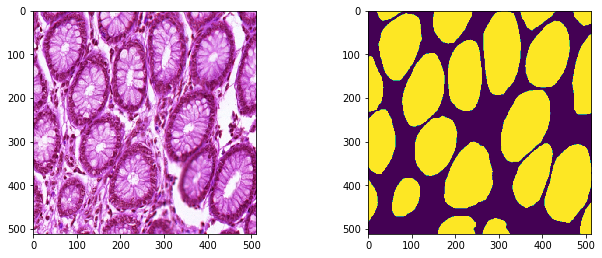

In [8]:

x,y = test_data.__getitem__(0)

print(x.shape,y.shape)

r=random.randint(0,len(x)-1);

fig = plt.figure(figsize=(10,10));
fig.subplots_adjust(hspace=0.5,wspace=0.5)
ax = fig.add_subplot(1,2,1)
ax.imshow(x[r][:,:])
ax = fig.add_subplot(1,2,2)
ax.imshow(np.reshape(y[r],image_size))

In [9]:
#vgg unet
def down_block(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    p = keras.layers.MaxPool2D((2,2),(2,2))(c);
    
    return c,p

def up_block(x,skip,filters,kernel_size=(3,3),padding="same",strides=1):
    us=keras.layers.UpSampling2D((2,2))(x);
    concat = keras.layers.Concatenate()([us,skip])
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(concat);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(concat);
    return c;


def bottleneck(x,filters,kernel_size=(3,3),padding="same",strides=1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(x);
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation="relu")(c);
    return c;

In [10]:
def UNet():
    f = [16,32,64,128,256,512];
    
    inputs = keras.layers.Input(image_size+(3,))
    
    p0=inputs;
    c1,p1 = down_block(p0,f[0])  
    c2,p2 = down_block(p1,f[1]) 
    c3,p3 = down_block(p2,f[2])
    c4,p4 = down_block(p3,f[3]) 
    c5,p5 = down_block(p4,f[4])
    
    bn = bottleneck(p5,f[5])
    
    u5= up_block(bn,c5,f[4])
    u4= up_block(u5,c4,f[3])  
    u3= up_block(u4,c3,f[2])
    u2= up_block(u3,c2,f[1])
    u1= up_block(u2,c1,f[0])
    
    outputs = keras.layers.Conv2D(1,(1,1),padding="same",activation='sigmoid')(u1);
    model = keras.models.Model(inputs,outputs)
    
    return model

In [69]:
smooth=1;

def dice_coef(y_true,y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f* y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+ smooth )
    
def dice_coef_loss(y_true,y_pred):
    return 1.0- dice_coef(y_true,y_pred)

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model = UNet();

In [161]:

model.compile(optimizer = "adam",loss="binary_crossentropy",metrics=['acc',f1_m,precision_m, recall_m,dice_coef_loss]);
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [160]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model1check.hdf5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')


In [162]:
for i in range(30):
    valids= random.sample(train_ids,15);
    traids= [x for x in train_ids if x not in valids];
    train_data = DataLoader(traids,batch_size=batch_size,image_size = image_size,aug=True)
    valid_data = DataLoader(valids,batch_size=batch_size,image_size = image_size)
    
    train_steps= len(traids)//batch_size;
    valid_steps= len(valids)//batch_size;
    
    epochs = 40;
    model.load_weights("model1check.hdf5")
    result = model.fit_generator(train_data, validation_data=valid_data, 
                                 steps_per_epoch=train_steps, 
                                 validation_steps=valid_steps, 
                                epochs=epochs,callbacks=[checkpoint])
    

Epoch 1/50
6/7 [========================>.....] - ETA: 8s - loss: 0.3661 - acc: 0.8394 - f1_m: 0.8376 - precision_m: 0.8517 - recall_m: 0.8293 - dice_coef_loss: 0.2317 
Epoch 00001: val_loss improved from inf to 0.31837, saving model to model1check.hdf5
7/7 [==============================] - 63s 9s/step - loss: 0.3533 - acc: 0.8484 - f1_m: 0.8473 - precision_m: 0.8570 - recall_m: 0.8425 - dice_coef_loss: 0.2213 - val_loss: 0.3184 - val_acc: 0.8565 - val_f1_m: 0.8584 - val_precision_m: 0.8732 - val_recall_m: 0.8440 - val_dice_coef_loss: 0.2173
Epoch 2/50
6/7 [========================>.....] - ETA: 8s - loss: 0.2997 - acc: 0.8673 - f1_m: 0.8649 - precision_m: 0.8614 - recall_m: 0.8689 - dice_coef_loss: 0.1978 
Epoch 00002: val_loss improved from 0.31837 to 0.27690, saving model to model1check.hdf5
7/7 [==============================] - 63s 9s/step - loss: 0.3074 - acc: 0.8638 - f1_m: 0.8635 - precision_m: 0.8680 - recall_m: 0.8603 - dice_coef_loss: 0.1990 - val_loss: 0.2769 - val_acc: 0.

Epoch 32/50
6/7 [========================>.....] - ETA: 12s - loss: 0.1144 - acc: 0.9458 - f1_m: 0.9498 - precision_m: 0.9518 - recall_m: 0.9478 - dice_coef_loss: 0.0713
Epoch 00032: val_loss did not improve from 0.18977
7/7 [==============================] - 91s 13s/step - loss: 0.1166 - acc: 0.9452 - f1_m: 0.9492 - precision_m: 0.9518 - recall_m: 0.9466 - dice_coef_loss: 0.0715 - val_loss: 0.2544 - val_acc: 0.9042 - val_f1_m: 0.9068 - val_precision_m: 0.9337 - val_recall_m: 0.8814 - val_dice_coef_loss: 0.1127
Epoch 33/50
6/7 [========================>.....] - ETA: 12s - loss: 0.1322 - acc: 0.9401 - f1_m: 0.9440 - precision_m: 0.9474 - recall_m: 0.9408 - dice_coef_loss: 0.0762
Epoch 00033: val_loss did not improve from 0.18977
7/7 [==============================] - 92s 13s/step - loss: 0.1300 - acc: 0.9409 - f1_m: 0.9450 - precision_m: 0.9455 - recall_m: 0.9447 - dice_coef_loss: 0.0762 - val_loss: 0.2824 - val_acc: 0.8910 - val_f1_m: 0.8949 - val_precision_m: 0.9035 - val_recall_m: 0.

Epoch 48/50
6/7 [========================>.....] - ETA: 12s - loss: 0.0904 - acc: 0.9549 - f1_m: 0.9601 - precision_m: 0.9614 - recall_m: 0.9589 - dice_coef_loss: 0.0531
Epoch 00048: val_loss did not improve from 0.18977
7/7 [==============================] - 91s 13s/step - loss: 0.0874 - acc: 0.9563 - f1_m: 0.9604 - precision_m: 0.9612 - recall_m: 0.9596 - dice_coef_loss: 0.0527 - val_loss: 0.3328 - val_acc: 0.8908 - val_f1_m: 0.8919 - val_precision_m: 0.9298 - val_recall_m: 0.8570 - val_dice_coef_loss: 0.1202
Epoch 49/50
6/7 [========================>.....] - ETA: 12s - loss: 0.0781 - acc: 0.9603 - f1_m: 0.9625 - precision_m: 0.9621 - recall_m: 0.9629 - dice_coef_loss: 0.0516
Epoch 00049: val_loss did not improve from 0.18977
7/7 [==============================] - 91s 13s/step - loss: 0.0817 - acc: 0.9583 - f1_m: 0.9625 - precision_m: 0.9617 - recall_m: 0.9633 - dice_coef_loss: 0.0514 - val_loss: 0.2977 - val_acc: 0.9046 - val_f1_m: 0.9080 - val_precision_m: 0.9270 - val_recall_m: 0.

Epoch 14/45
6/7 [========================>.....] - ETA: 12s - loss: 0.1652 - acc: 0.9251 - f1_m: 0.9312 - precision_m: 0.9254 - recall_m: 0.9376 - dice_coef_loss: 0.0980
Epoch 00014: val_loss did not improve from 0.14720
7/7 [==============================] - 90s 13s/step - loss: 0.1612 - acc: 0.9265 - f1_m: 0.9311 - precision_m: 0.9287 - recall_m: 0.9340 - dice_coef_loss: 0.0983 - val_loss: 0.1816 - val_acc: 0.9322 - val_f1_m: 0.9303 - val_precision_m: 0.9494 - val_recall_m: 0.9120 - val_dice_coef_loss: 0.1005
Epoch 15/45
6/7 [========================>.....] - ETA: 12s - loss: 0.1647 - acc: 0.9253 - f1_m: 0.9321 - precision_m: 0.9341 - recall_m: 0.9305 - dice_coef_loss: 0.0974
Epoch 00015: val_loss did not improve from 0.14720
7/7 [==============================] - 92s 13s/step - loss: 0.1631 - acc: 0.9258 - f1_m: 0.9307 - precision_m: 0.9380 - recall_m: 0.9241 - dice_coef_loss: 0.0991 - val_loss: 0.1705 - val_acc: 0.9283 - val_f1_m: 0.9252 - val_precision_m: 0.9588 - val_recall_m: 0.

Epoch 30/45
6/7 [========================>.....] - ETA: 10s - loss: 0.1177 - acc: 0.9444 - f1_m: 0.9515 - precision_m: 0.9549 - recall_m: 0.9483 - dice_coef_loss: 0.0688
Epoch 00030: val_loss did not improve from 0.14710
7/7 [==============================] - 76s 11s/step - loss: 0.1141 - acc: 0.9462 - f1_m: 0.9512 - precision_m: 0.9517 - recall_m: 0.9511 - dice_coef_loss: 0.0696 - val_loss: 0.1772 - val_acc: 0.9314 - val_f1_m: 0.9298 - val_precision_m: 0.9445 - val_recall_m: 0.9156 - val_dice_coef_loss: 0.0910
Epoch 31/45
6/7 [========================>.....] - ETA: 10s - loss: 0.1114 - acc: 0.9472 - f1_m: 0.9545 - precision_m: 0.9600 - recall_m: 0.9493 - dice_coef_loss: 0.0644
Epoch 00031: val_loss did not improve from 0.14710
7/7 [==============================] - 77s 11s/step - loss: 0.1073 - acc: 0.9490 - f1_m: 0.9543 - precision_m: 0.9596 - recall_m: 0.9491 - dice_coef_loss: 0.0648 - val_loss: 0.1716 - val_acc: 0.9336 - val_f1_m: 0.9333 - val_precision_m: 0.9335 - val_recall_m: 0.

Epoch 1/40
6/7 [========================>.....] - ETA: 10s - loss: 0.1345 - acc: 0.9403 - f1_m: 0.9454 - precision_m: 0.9460 - recall_m: 0.9449 - dice_coef_loss: 0.0747
Epoch 00001: val_loss improved from 0.14710 to 0.10790, saving model to model1check.hdf5
7/7 [==============================] - 78s 11s/step - loss: 0.1369 - acc: 0.9391 - f1_m: 0.9439 - precision_m: 0.9454 - recall_m: 0.9426 - dice_coef_loss: 0.0780 - val_loss: 0.1079 - val_acc: 0.9514 - val_f1_m: 0.9568 - val_precision_m: 0.9650 - val_recall_m: 0.9487 - val_dice_coef_loss: 0.0715
Epoch 2/40
6/7 [========================>.....] - ETA: 10s - loss: 0.1302 - acc: 0.9409 - f1_m: 0.9462 - precision_m: 0.9445 - recall_m: 0.9481 - dice_coef_loss: 0.0802
Epoch 00002: val_loss did not improve from 0.10790
7/7 [==============================] - 76s 11s/step - loss: 0.1350 - acc: 0.9399 - f1_m: 0.9441 - precision_m: 0.9483 - recall_m: 0.9405 - dice_coef_loss: 0.0814 - val_loss: 0.1102 - val_acc: 0.9503 - val_f1_m: 0.9558 - val_pr

Epoch 17/40
6/7 [========================>.....] - ETA: 10s - loss: 0.1008 - acc: 0.9511 - f1_m: 0.9565 - precision_m: 0.9555 - recall_m: 0.9576 - dice_coef_loss: 0.0609
Epoch 00017: val_loss did not improve from 0.10790
7/7 [==============================] - 77s 11s/step - loss: 0.1001 - acc: 0.9516 - f1_m: 0.9564 - precision_m: 0.9563 - recall_m: 0.9565 - dice_coef_loss: 0.0608 - val_loss: 0.1485 - val_acc: 0.9344 - val_f1_m: 0.9394 - val_precision_m: 0.9627 - val_recall_m: 0.9173 - val_dice_coef_loss: 0.0763
Epoch 18/40
6/7 [========================>.....] - ETA: 10s - loss: 0.0954 - acc: 0.9530 - f1_m: 0.9575 - precision_m: 0.9569 - recall_m: 0.9582 - dice_coef_loss: 0.0582
Epoch 00018: val_loss did not improve from 0.10790
7/7 [==============================] - 78s 11s/step - loss: 0.0961 - acc: 0.9530 - f1_m: 0.9575 - precision_m: 0.9565 - recall_m: 0.9585 - dice_coef_loss: 0.0586 - val_loss: 0.1217 - val_acc: 0.9428 - val_f1_m: 0.9483 - val_precision_m: 0.9608 - val_recall_m: 0.

Epoch 33/40
6/7 [========================>.....] - ETA: 10s - loss: 0.0696 - acc: 0.9632 - f1_m: 0.9695 - precision_m: 0.9703 - recall_m: 0.9688 - dice_coef_loss: 0.0420
Epoch 00033: val_loss did not improve from 0.10790
7/7 [==============================] - 78s 11s/step - loss: 0.0678 - acc: 0.9642 - f1_m: 0.9688 - precision_m: 0.9687 - recall_m: 0.9690 - dice_coef_loss: 0.0429 - val_loss: 0.1323 - val_acc: 0.9448 - val_f1_m: 0.9510 - val_precision_m: 0.9536 - val_recall_m: 0.9484 - val_dice_coef_loss: 0.0612
Epoch 34/40
6/7 [========================>.....] - ETA: 11s - loss: 0.0649 - acc: 0.9652 - f1_m: 0.9707 - precision_m: 0.9697 - recall_m: 0.9717 - dice_coef_loss: 0.0397
Epoch 00034: val_loss did not improve from 0.10790
7/7 [==============================] - 79s 11s/step - loss: 0.0640 - acc: 0.9656 - f1_m: 0.9705 - precision_m: 0.9694 - recall_m: 0.9717 - dice_coef_loss: 0.0396 - val_loss: 0.1487 - val_acc: 0.9405 - val_f1_m: 0.9467 - val_precision_m: 0.9529 - val_recall_m: 0.